In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import operator
import time
import warnings

warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score, roc_curve
from sklearn import preprocessing


start_time = time.time()
data = pd.read_excel('data/paper_data.xlsx')
print('---------- Reading file use %.2fs ----------' % (time.time()-start_time))

# Delete features with identical values
data.drop(['END_DATE', 'REPORT_TYPE', 'FISCAL_PERIOD',
           'MERGED_FLAG', 'ACCOUTING_STANDARDS', 'CURRENCY_CD'], axis='columns', inplace=True)
# Delete features that have no practical significance
data.drop(['TICKER_SYMBOL', 'ACT_PUBTIME', 'PUBLISH_DATE', 'END_DATE_REP'], axis='columns', inplace=True)
data["FLAG"] = data["FLAG"].astype(int)
data.info()

---------- Reading file use 3.11s ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954 entries, 0 to 1953
Columns: 353 entries, CASH_C_EQUIV to FLAG
dtypes: float64(352), int32(1)
memory usage: 5.3 MB


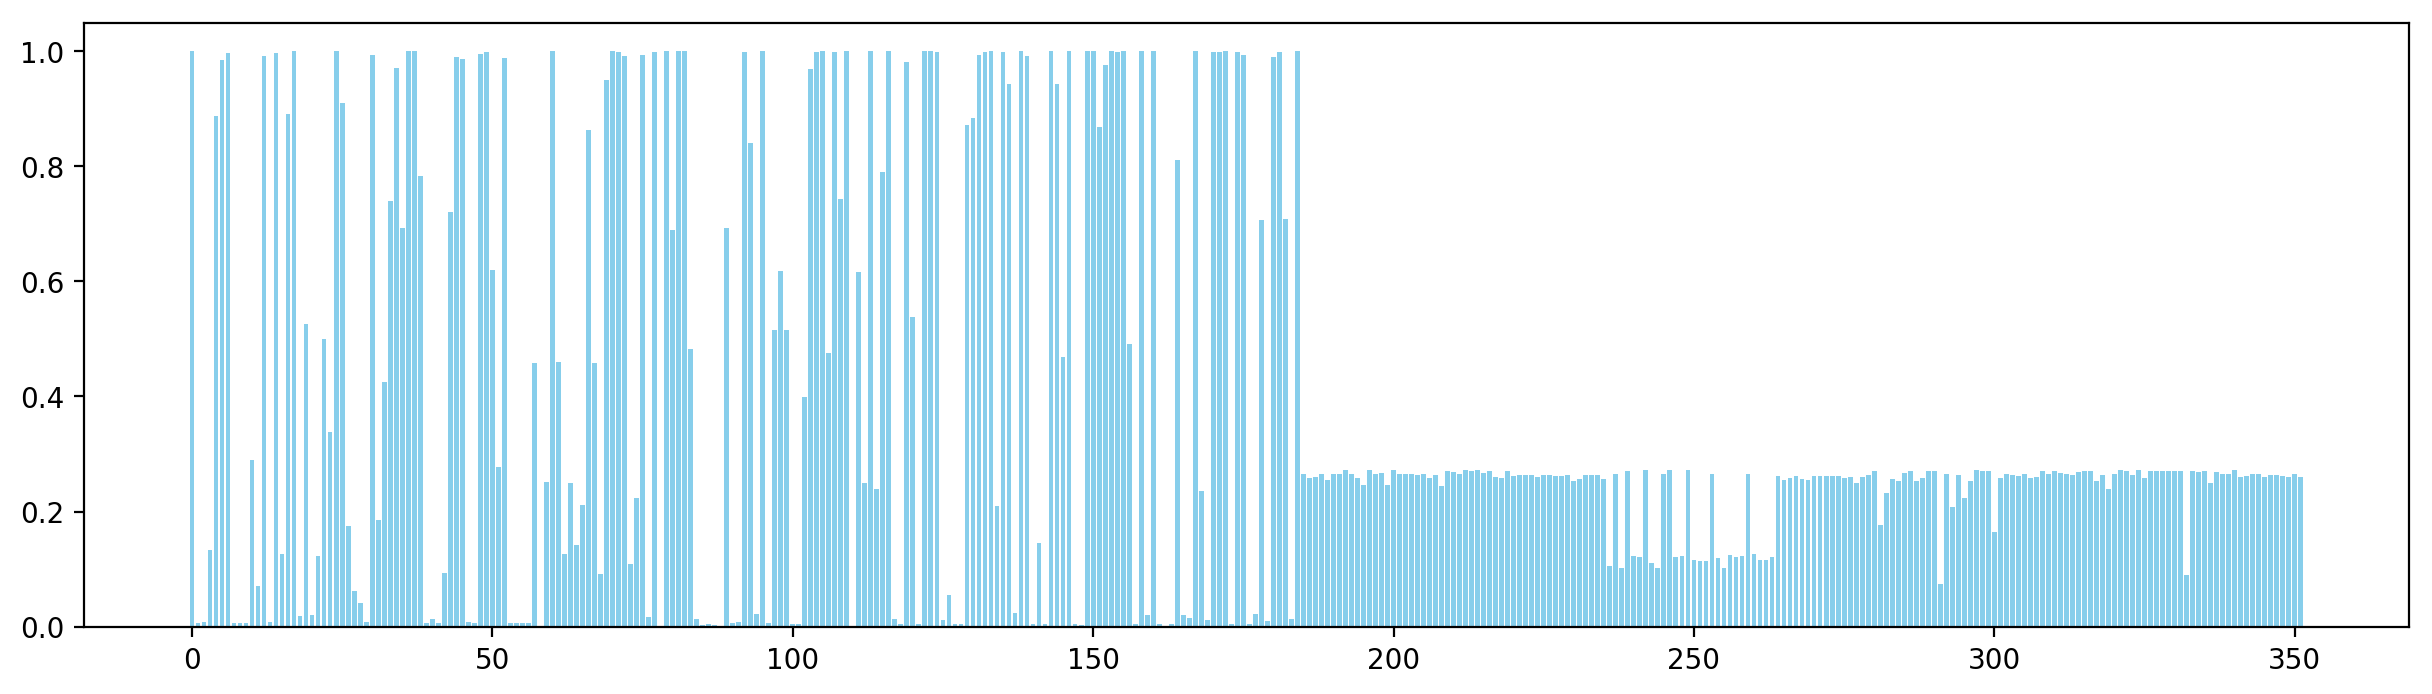

In [2]:
# Data visualization
def missing_visualization(data):
    missing_value = []
    retention_value = []
    missing_light = []
    missing_moderate = []
    missing_severe = []
    num_col = data.shape[0]
    for column in data.columns:
        num_null = data[column].isnull().sum(axis=0)
        missing_rate = num_null/num_col
        retention_rate = 1 - missing_rate
        if missing_rate < 0.35 or num_null == 0:
            missing_light.append(column)
        elif missing_rate < 0.75:
            missing_moderate.append(column)
        else:
            missing_severe.append(column)  
        missing_value.append(missing_rate)
        retention_value.append(retention_rate)
        
    missing_value = missing_value[:-1]
    retention_value = retention_value[:-1]
    
    index = np.arange(data.shape[1] - 1)
    plt.figure(figsize=(15, 4), dpi=200)
    plt.bar(index, retention_value, color='skyblue')
    # plt.bar(index, missing_value, color='darkred')
    
    return missing_light, missing_moderate, missing_severe
    
missing_light, missing_moderate, missing_severe = missing_visualization(data)


In [3]:
# Optimization of KNN algorithm parameters using random forests
rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

def optimize_knn(data, target):
    errors = []
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=data.columns)
        
        x = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

        model = RandomForestClassifier()
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        auc = accuracy_score(y_test, y_pred)
        errors.append({'K': k, 'Auccuary': auc})
        # recall = recall_score(y_test, y_pred)
        # precision = precision_score(y_test, y_pred)
        # errors.append({'K': k, 'Auccuary': auc, 'Recall': recall, 'Percision': precision})
        
    return errors


In [4]:
# Preprocess data
start_time = time.time()

# Delete features with a missing rate greater than 0.75
for column in missing_severe:
    if column in data.columns:
        data.drop(column, axis='columns', inplace=True)
print('---------- End of phase I processing ----------')

# The missing value of features with a missing rate greater than 0.35 but less than 0.75 shall be supplemented with 0
for column in missing_moderate:
    if column in data.columns:
        data[column].fillna(0, inplace = True)
print('---------- End of phase Ⅱ processing ----------')
    
# Use KNN to supplement features with missing rate less than 0.35
# Automatically adjust KNN parameters
# k_errors = optimize_knn(data, 'FLAG')
# k_errors = sorted(k_errors, key=operator.itemgetter('Auccuary'))
# k_best = k_errors[0]['K']
# imputer = KNNImputer(n_neighbors=k_best)
# imputed = imputer.fit_transform(data)
# data = pd.DataFrame(imputed, columns=data.columns)

# data_a = data[data['FLAG'].isin([0])]
# data_b = data[data['FLAG'].isin([1])]

# imputer = KNNImputer(n_neighbors=15)
# imputed_a = imputer.fit_transform(data_a)
# imputed_b = imputer.fit_transform(data_b)
# imputed = np.append(imputed_a, imputed_b, axis=0)
# data = pd.DataFrame(imputed, columns=data.columns)

imputer = KNNImputer(n_neighbors=15)
imputed = imputer.fit_transform(data)
data = pd.DataFrame(imputed, columns=data.columns)
print('---------- End of phase Ⅲ processing ----------')

print('---------- Preprocessing data %.2fs ----------' % (time.time()-start_time))

data.info()

---------- End of phase I processing ----------
---------- End of phase Ⅱ processing ----------
---------- End of phase Ⅲ processing ----------
---------- Preprocessing data 1.29s ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954 entries, 0 to 1953
Columns: 242 entries, CASH_C_EQUIV to FLAG
dtypes: float64(242)
memory usage: 3.6 MB


# Feature selection

In [5]:
# Feature selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb

start_time = time.time()

x, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
feat_labels = data.columns[:-1]


In [6]:
# Random Forest
rfc_model = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rfc_model.fit(x, y)

rfc_imp = rfc_model.feature_importances_
indices = np.argsort(rfc_imp)[::-1]
rfc_imp_30 = []
for f in range(x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], rfc_imp[indices[f]]))
    if f < 30:
        rfc_imp_30.append(feat_labels[indices[f]])

 1) NOPERATE_EXP                   0.055946
 2) C_OUTF_FR_INVEST_A             0.041548
 3) OTH_CA                         0.021144
 4) RETAINED_EARNINGS              0.020690
 5) MINORITY_INT                   0.016529
 6) CASH_C_EQUIV                   0.015315
 7) PUR_FIX_ASSETS_OTH             0.014940
 8) C_INF_FR_OPERATE_A             0.013158
 9) C_FR_SALE_G_S                  0.013034
10) T_REVENUE                      0.012125
11) REVENUE                        0.010923
12) COMPR_INC_ATTR_M_S             0.010605
13) N_CF_FR_INVEST_A               0.010310
14) OTH_PAYABLE                    0.009293
15) C_OUTF_OPERATE_A               0.009253
16) INVENTORIES                    0.009090
17) BTAX_SURCHG_TR                 0.008417
18) T_NCL                          0.008251
19) MINORITY_GAIN                  0.008240
20) DISP_FIX_ASSETS_OTH            0.008231
21) NOTES_PAYABLE                  0.007919
22) ADMIN_EXP                      0.007821
23) ADVANCE_RECEIPTS            

In [7]:
# Gradient Boosting Decision Tree
gbdt_model = GradientBoostingClassifier(n_estimators=30, learning_rate=0.5, max_depth=10, min_samples_leaf=50, 
                                        min_samples_split=40, subsample=0.4, random_state=42)
gbdt_model.fit(x, y)

gbdt_imp = gbdt_model.feature_importances_
indices = np.argsort(gbdt_imp)[::-1]
gbdt_imp_30 = []
for f in range(x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], gbdt_imp[indices[f]]))
    if f < 30:
        gbdt_imp_30.append(feat_labels[indices[f]])

 1) NOPERATE_EXP                   0.827969
 2) RETAINED_EARNINGS              0.042678
 3) C_OUTF_FR_INVEST_A             0.026438
 4) N_CF_FR_INVEST_A               0.014656
 5) OTH_CA                         0.013952
 6) T_LIAB_EQUITY                  0.010990
 7) MINORITY_INT                   0.006998
 8) PUR_FIX_ASSETS_OTH             0.006105
 9) CAP_FIX_RATIO                  0.004038
10) INT_DEBT                       0.003602
11) NOTES_PAYABLE                  0.003495
12) SELL_EXP_TR                    0.003495
13) REV_PS                         0.003460
14) C_FR_OTH_FINAN_A               0.002715
15) T_REVENUE                      0.002531
16) OTH_PAYABLE                    0.002356
17) LT_AMOR_EXP                    0.002263
18) BASIC_EPS                      0.002222
19) N_INCOME_ATTR_P                0.001877
20) C_PAID_FOR_OTH_OP_A            0.001794
21) C_PAID_OTH_INVEST_A            0.001684
22) NOTES_RECEIV                   0.001477
23) MINORITY_GAIN               

In [8]:
# Light Gradient Boosting Machine
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 30,
    'num_round': 360,
    'max_depth':8,
    'learning_rate': 0.01,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.8,
    'bagging_freq': 12,
    'verbose': -1
}
target = 'FLAG'
lgb_train = lgb.Dataset(x, y)
lgb_model = lgb.train(lgb_params, lgb_train)

lgb_imp = lgb_model.feature_importance()
indices = np.argsort(lgb_imp)[::-1]
lgb_imp_30 = []
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], lgb_imp[indices[f]]))
    if f < 30:
        lgb_imp_30.append(feat_labels[indices[f]])

 1) NOPERATE_EXP                   574.000000
 2) RETAINED_EARNINGS              476.000000
 3) C_OUTF_FR_INVEST_A             339.000000
 4) PUR_FIX_ASSETS_OTH             336.000000
 5) MINORITY_INT                   238.000000
 6) DILUTED_EPS                    218.000000
 7) N_CF_FR_INVEST_A               194.000000
 8) OTH_CA                         179.000000
 9) C_FR_OTH_FINAN_A               172.000000
10) OPERATE_PROFIT                 158.000000
11) NCA_DISPLOSS                   143.000000
12) COMPR_INC_ATTR_P               133.000000
13) BASIC_EPS                      129.000000
14) SURPLUS_RESER                  118.000000
15) REFUND_OF_TAX                  109.000000
16) N_CF_OPERATE_A                 109.000000
17) N_CF_IA_PROPT                  106.000000
18) INVEST_INCOME                  103.000000
19) OTH_PAYABLE                    103.000000
20) N_INCOME_ATTR_P                101.000000
21) C_FR_OTH_OPERATE_A             99.000000
22) T_EQUITY_ATTR_P                

In [9]:
# eXtreme Gradient Boosting
xgb_model = XGBClassifier(max_depth=6, learning_rate=0.8, n_estimators=50, subsample=0.8, min_child_weight=6, random_state=42)
xgb_model.fit(x, y)

xgb_imp = xgb_model.feature_importances_
indices = np.argsort(xgb_imp)[::-1]
xgb_imp_30 = []
for f in range(x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], xgb_imp[indices[f]]))
    if f < 30:
        xgb_imp_30.append(feat_labels[indices[f]])

 1) REFUND_OF_TAX                  0.131573
 2) NOPERATE_EXP                   0.117156
 3) C_OUTF_FR_INVEST_A             0.110515
 4) DILUTED_EPS                    0.109789
 5) RETAINED_EARNINGS              0.098650
 6) ASSETS_IMPAIR_LOSS             0.094130
 7) OTH_PAYABLE                    0.076974
 8) OTH_CA                         0.071771
 9) LT_AMOR_EXP                    0.071669
10) PREPAYMENT                     0.034452
11) PAID_IN_CAPITAL                0.033432
12) C_FR_OTH_FINAN_A               0.031308
13) MINORITY_INT                   0.010650
14) FINAN_EXP_TR                   0.007929
15) T_PROFIT                       0.000000
16) NCA_DISPLOSS                   0.000000
17) ADMIN_EXP                      0.000000
18) T_REVENUE                      0.000000
19) REVENUE                        0.000000
20) A_J_INVEST_INCOME              0.000000
21) BASIC_EPS                      0.000000
22) AR_TURNOVER                    0.000000
23) C_OUTF_FR_FINAN_A           

In [10]:
# Adaptive Boosting 
bdt_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_split=20, min_samples_leaf=5),
                               algorithm="SAMME", n_estimators=200, learning_rate=0.8)
bdt_model.fit(x, y)

bdt_imp = bdt_model.feature_importances_
indices = np.argsort(bdt_imp)[::-1]
bdt_imp_30 = []
for f in range(x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], bdt_imp[indices[f]]))
    if f < 30:
        bdt_imp_30.append(feat_labels[indices[f]])

 1) RETAINED_EARNINGS              0.133644
 2) NOPERATE_EXP                   0.080247
 3) C_OUTF_FR_INVEST_A             0.065234
 4) MINORITY_INT                   0.056284
 5) OTH_CA                         0.049645
 6) DILUTED_EPS                    0.033189
 7) DEFER_TAX_LIAB                 0.032843
 8) OTH_PAYABLE                    0.029326
 9) NCA_DISPLOSS                   0.023370
10) C_FR_OTH_FINAN_A               0.020482
11) N_CF_OPERATE_A                 0.015388
12) INVEST_INCOME                  0.014810
13) C_INF_FR_INVEST_A              0.014534
14) REFUND_OF_TAX                  0.013962
15) C_INF_FR_OPERATE_A             0.013738
16) COMPR_INC_ATTR_M_S             0.012876
17) FOREX_EFFECTS                  0.012702
18) C_PAID_INVEST                  0.012539
19) OTH_NCA                        0.012005
20) N_CF_OPA_PROPT                 0.011375
21) N_CF_FR_INVEST_A               0.011329
22) AIL_TR                         0.011048
23) NOTES_RECEIV                

['RETAINED_EARNINGS', 'OTH_PAYABLE', 'OTH_CA', 'NOPERATE_EXP', 'MINORITY_INT', 'C_OUTF_FR_INVEST_A', 'REFUND_OF_TAX', 'PUR_FIX_ASSETS_OTH', 'N_CF_FR_INVEST_A', 'INVEST_INCOME', 'C_FR_OTH_FINAN_A', 'T_REVENUE', 'OPERATE_PROFIT', 'NCA_DISPLOSS', 'MINORITY_GAIN', 'DISP_FIX_ASSETS_OTH', 'DILUTED_EPS', 'BASIC_EPS']
Select 19 features
---------- Feature selection use 16.83s ----------


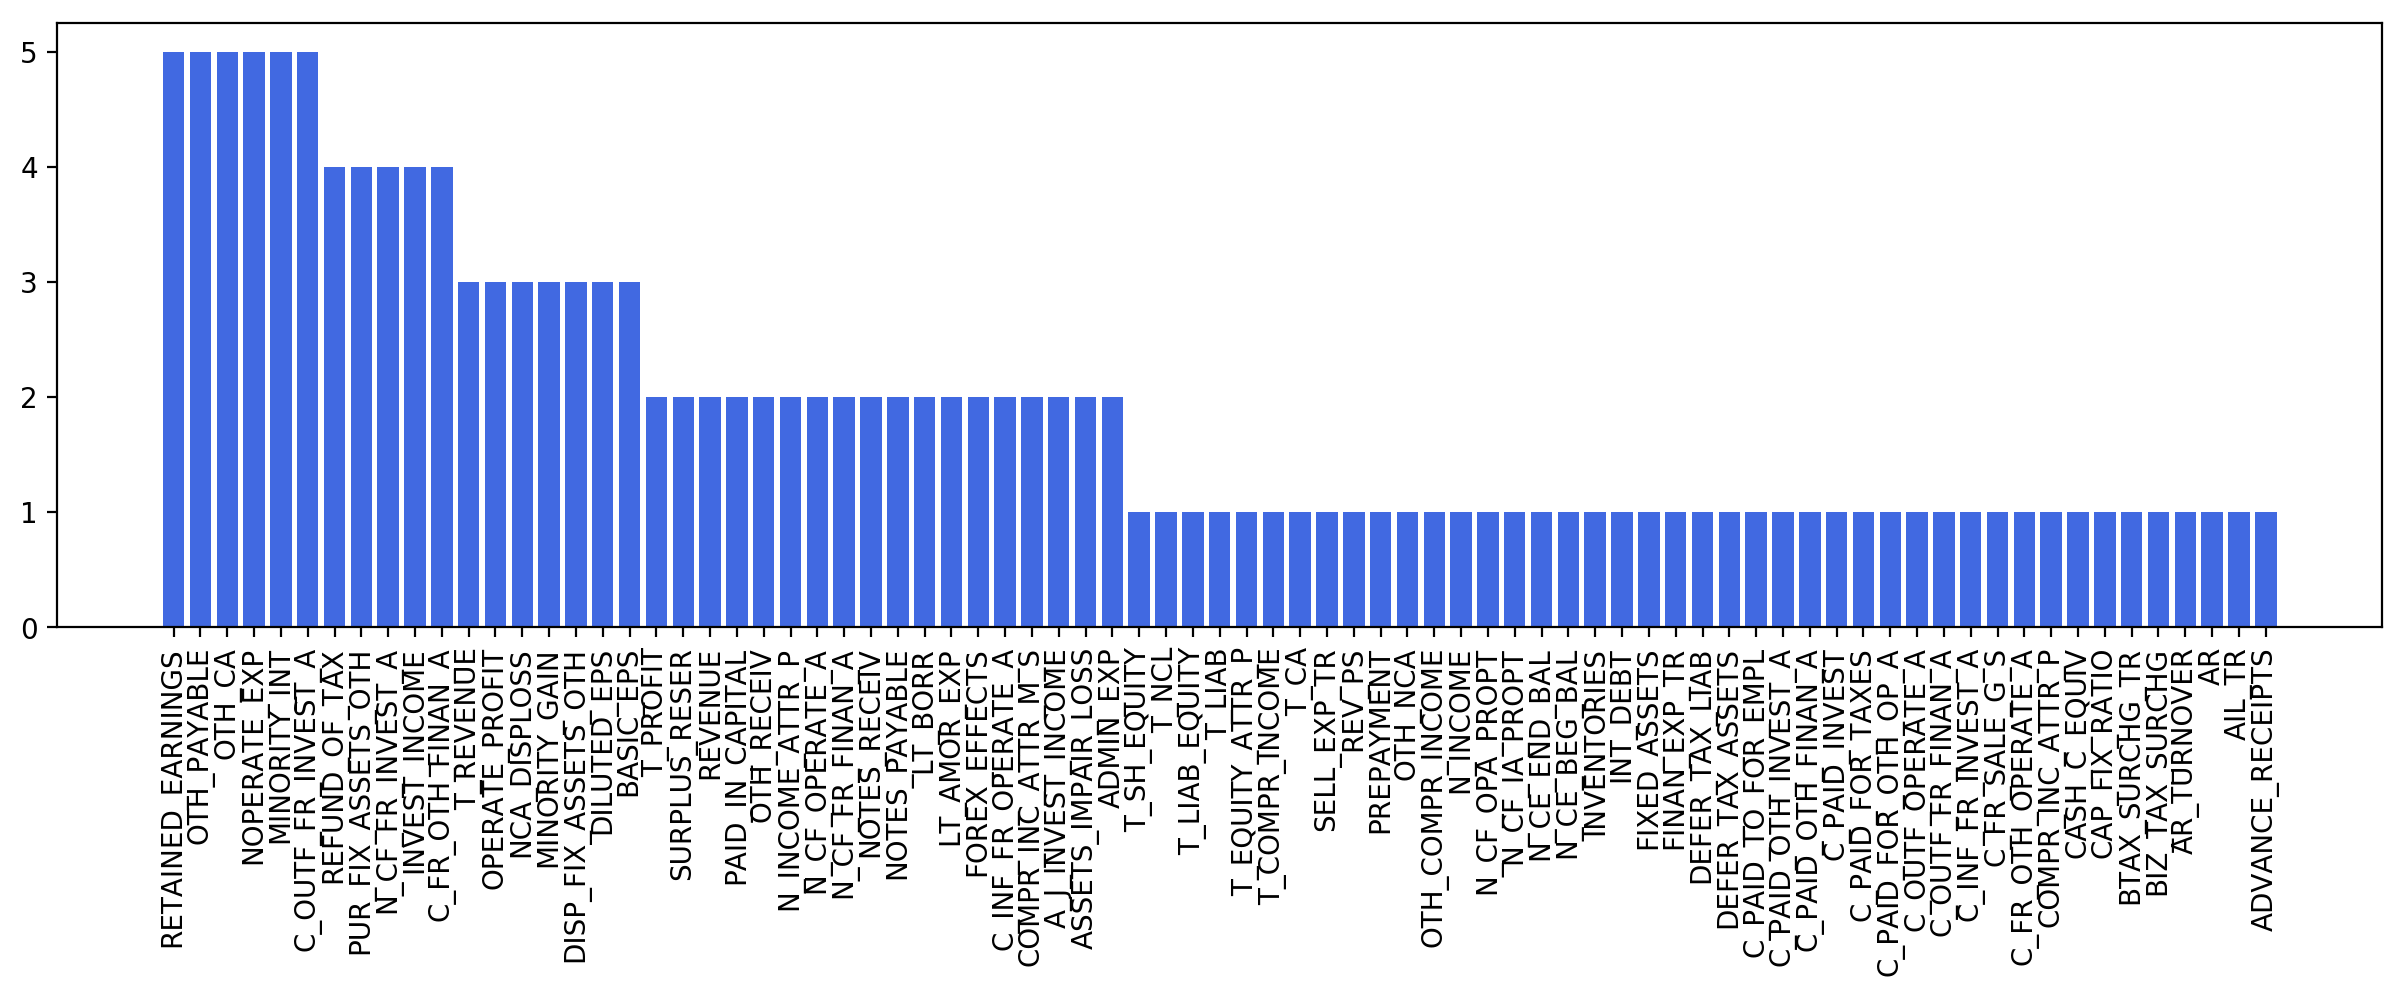

In [11]:
# Select the top 30 features of each algorithm for voting and scoring
imp_30 = np.array([rfc_imp_30, gbdt_imp_30, lgb_imp_30, xgb_imp_30, bdt_imp_30])
imp_feature, imp_score = np.unique(imp_30, return_counts=True)
Z = zip(imp_score, imp_feature)
Z = sorted(Z, reverse=True)
imp_score, imp_feature = zip(*Z)

plt.figure(figsize=(15, 4), dpi=200)
plt.xticks(rotation=90)
plt.bar(imp_feature, imp_score, color='royalblue')

sel_feature = []
for i in range(0, len(imp_feature)):
    if imp_score[i] >= 3:
        sel_feature.append(imp_feature[i])
print(sel_feature)

sel_feature.append('FLAG')
data = data[sel_feature]

print('Select %d features' % len(sel_feature))
print('---------- Feature selection use %.2fs ----------' % (time.time()-start_time))

# Tuning parameter

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

x, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

def grid_display(grid):
    means = grid.cv_results_['mean_test_score']
    params = grid.cv_results_['params']
    for mean, param in zip(means,params):
        print("%f  with:   %r" % (mean,param))

In [33]:
# Logistic Regression
param = {'C':[0.0001, 0.01, 1]}
grid = GridSearchCV(LogisticRegression(penalty='l2', dual=False,tol=1e4, fit_intercept=True, intercept_scaling=1,
                                       class_weight=None, random_state=42, solver='liblinear', max_iter=100,
                                       multi_class='ovr', verbose=0, warm_start=False, n_jobs=1), param_grid=param, scoring='roc_auc', cv=3)
grid.fit(x, y)
print('最优分类器:',grid.best_params_,'最优分数:', grid.best_score_)

最优分类器: {'C': 0.0001} 最优分数: 0.5


In [38]:
# Random Forest
param = {'n_estimators':[int(x) for x in np.linspace(start = 200,stop = 800, num = 4)],
         'max_depth':[5, 10, 15],
         'min_samples_split':[1, 2, 5],
         'min_samples_leaf':[1, 2, 5],
         'max_features':['auto', 'sqrt'],
         'bootstrap':[True, False]}
grid = GridSearchCV(RandomForestClassifier(criterion='gini', max_features='auto', bootstrap=False, random_state=42),
                    param_grid=param, scoring='f1', cv=3)
grid.fit(x, y)
rfc_parameters = grid.best_estimator_.get_params()
print('最优分类器:',grid.best_params_,'最优分数:', grid.best_score_)
grid_display(grid)

最优分类器: {'n_estimators': 100} 最优分数: 0.9888975424022153


In [43]:
# Gradient Boosting Decision Tree
param = {'n_estimators':[int(x) for x in np.linspace(start = 200,stop = 800, num = 4)],
         'max_depth':[5, 8, 10],
         'subsample':[0.3, 0.5, 0.7],
         'learning_rate':[0.02, 0.05, 0.1, 0.5],
         'min_samples_split':[30, 35, 40],
         'min_samples_leaf':[30, 35, 40]}
grid = GridSearchCV(GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', max_features=None,
                                               max_leaf_nodes=None, min_impurity_decrease=0.0, random_state=42),
                    param_grid=param, scoring='f1', cv=3)
grid.fit(x, y)
gbdt_parameters = grid.best_estimator_.get_params()
print('最优分类器:',grid.best_params_,'最优分数:', grid.best_score_)
grid_display(grid)

最优分类器: {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 35, 'min_samples_split': 35, 'n_estimators': 400, 'subsample': 0.5} 最优分数: 0.6654456654456654


In [48]:
# eXtreme Gradient Boosting
param = {'n_estimators':[int(x) for x in np.linspace(start = 200,stop = 800, num = 4)],
         'max_depth':[3, 5, 8],
         'subsample':[0.1, 0.2, 0.3],
         'learning_rate':[0.5, 1]}
grid = GridSearchCV(XGBClassifier(booster='gbtree', gamma=0, colsample_bytree=0.8, alpha=0, random_state=42),
                    param_grid=param, scoring='f1', cv=3)
grid.fit(x, y)
xgb_parameters = grid.best_estimator_.get_params()
print('最优分类器:',grid.best_params_,'最优分数:', grid.best_score_)
grid_display(grid)

最优分类器: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.2} 最优分数: 0.6783559577677224


In [18]:
def get_stacking(clf, x_train, y_train, x_test, n_folds= 5):
    import numpy as np
    from sklearn.model_selection import KFold

    train_num, test_num = x_train.shape[0], x_test.shape[0]
    second_level_train_set = np.zeros((train_num,))
    second_level_test_set = np.zeros((test_num,))
    test_nfolds_sets = np.zeros((test_num, n_folds))
    kf = KFold(n_splits=n_folds)
    
    for i,(train_index, test_index) in enumerate(kf.split(x_train)):
        x_tra, y_tra = x_train.iloc[train_index,:], pd.DataFrame(y_train).iloc[train_index, :]
        x_tst, y_tst =  x_train.iloc[test_index,:], pd.DataFrame(y_train).iloc[test_index,:]
 
        clf.fit(x_tra, y_tra)
 
        second_level_train_set[test_index] = clf.predict(x_tst)
        test_nfolds_sets[:,i] = clf.predict(x_test)
 
    second_level_test_set[:] = test_nfolds_sets.mean(axis=1)
    return second_level_train_set, second_level_test_set

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

rfc_model = RandomForestClassifier(criterion='gini', max_features='auto', bootstrap=False, n_estimators=600,
                                   max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=42)
gbdt_model = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', max_features=None, n_estimators=400, max_depth=8,
                                        subsample=0.5, learning_rate=0.05, min_samples_split=35, min_samples_leaf=35,
                                        max_leaf_nodes=None, min_impurity_decrease=0.0, random_state=42)
xgb_model = XGBClassifier(booster='gbtree', gamma=0, colsample_bytree=0.8, alpha=0, n_estimators=600, max_depth=3,
                          subsample=0.2, learning_rate=1, random_state=42)
lr_model = LogisticRegression(penalty='l2', dual=False,tol=1e4, fit_intercept=True, intercept_scaling=1,
                                        class_weight=None, random_state=42, solver='liblinear', max_iter=100,
                                        multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
x_test = pd.DataFrame(x_test)

train_sets = []
test_sets = []
for clf in [rfc_model, gbdt_model, xgb_model]:
    train_set, test_set = get_stacking(clf, x_train, y_train, x_test)
    train_sets.append(train_set)
    test_sets.append(test_set)
     
meta_train =  pd.DataFrame(train_sets).T
meta_test =   pd.DataFrame(test_sets).T
       
# Second
rfc_model.fit(meta_train, y_train)
y_predict = pd.Series(rfc_model.predict(meta_test))
     
res = pd.DataFrame({'real_label':y_test,
                    'predict_label':y_predict.map(lambda x:float(x)).tolist()})


In [21]:
from sklearn.metrics import accuracy_score , precision_score ,recall_score , f1_score, roc_curve, auc
fpr, tpr, thresholds = metrics.roc_curve(res['real_label'] , res['predict_label'])
print('accuracy_score' , accuracy_score(res['real_label'] , res['predict_label']))
print('precision_score' , precision_score(res['real_label'] , res['predict_label']))
print('recall_score' , recall_score(res['real_label'] , res['predict_label']))
print('f1_score' , f1_score(res['real_label'] , res['predict_label']))
print('AUC', auc(fpr,tpr))

accuracy_score 0.9948849104859335
precision_score 0.8333333333333334
recall_score 0.8333333333333334
f1_score 0.8333333333333334
AUC 0.9153679653679655
